# 23 - Ejercicio: Topic Modeling - Noticias BBC News


* En el siguiente ejercicio tiene como objetivo aplicar los conocimientos adquiridos de ***Topic Modeling***, utilizando el LDA.


* Para ello vamos a trabajar con unos ***artículos de noticias publicados por la BBC*** que los tienen categorizados en 5 temas (Topics)

    - Business
    - Entertainment
    - Politics
    - Sport
    - Tech


* El objetivo de este ejercicio es el de ***obtener un número de temas (Topics) adecuados según los artículos y ver las relaciones entre los temas (Topics) y las palabras (Terms) que caracterizan a los temas (Topics)***.


* Pasos a realizar en el ejercicio:

    1. Carga de datos
    2. Normalizar los textos
    3. Creacción del diccionario y la bolsa de palabras
    4. Selección del número óptimo de Topics
    5. Creacción del Modelo
    6. Visualización

<hr>


## Carga de Datos


* El fichero en formato csv contiene una serie de noticias en los que le asigna una temática.


* Cada elemento del Json contiene:
    - **news**: Contenido del artículo
    - **type**: Temática
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

file = '../data/BBC_News.csv'
df = pd.read_csv(file, encoding="iso-8859-1")
documents = [str(x.encode('utf8')) for x in df.news.values] # Lista de documentos
df.sample(5)

,news,type
2041,Rings of steel combat net attacks\n \n Gamblin...,tech
684,Branson show flops on US screens\n \n Entrepre...,entertainment
1857,Go-ahead for new internet names\n \n The inter...,tech
520,Rock group Korn's guitarist quits\n \n The gui...,entertainment
1130,Tory expert denies defeat warning\n \n The Con...,politics


* Vemos los 5 tipos de artículos

In [2]:
df.groupby(['type']).count()

,news
type,
business,510
entertainment,386
politics,417
sport,511
tech,401


<hr>


## Normalizar los textos


* Utilizamos ***spaCy*** para la tokenización y normalización.


* Para ***normalizar*** los artículos realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 4 caracteres.
    4. Eliminamos las palabras con mas de 12 caracteres.
    5. Eliminamos las Stop-Words.
    6. Eliminamos los emails
    7. Eliminamos los saltos de linea
    8. Filtramos las palabras que no sean Nombre, Adjetivo, Verbo o Adverbio
    9. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.

In [3]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')


def normalize(corpus):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, doc in enumerate(corpus):
        doc = nlp(doc.lower().replace('\\\\n',''))
        corpus[index] = " ".join([word.lemma_ for word in doc if (not word.is_punct)
                                  and (len(word.text) > 3) 
                                  and (len(word.text) < 11) 
                                  and (not word.is_stop)
                                  and re.sub('\S*@\S*\s?', '', word.text)
                                  and re.sub('\s+', ' ', word.text)
                                  and (word.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])])
        
        
    return corpus

# Normalizamos las frases
corpus_norm = normalize(documents)

<hr>


## Creacción del diccionario y la bolsa de palabras


* En este punto tenemos que crear:
    - Corpus tokenizado: "*documents_tok*"
    - Diccionario: "*dictionary*"
    - Corpus: "*corpus*' que es la bolsa de palabras de gensim

In [4]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Tokenizamos
documents_tok = [word.split() for word in corpus_norm]

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in documents_tok:
    for token in doc:
        frequency[token] += 1
        
documents = [[token for token in doc] for doc in documents_tok]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary(15415 unique tokens: ['27bn', 'able', 'accord', 'agree', 'ambition']...)

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 3), (19, 2), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 6), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 5), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 4), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), 

<hr>


## Selección del número óptimo de Topics

In [5]:
warnings.filterwarnings('ignore')
from gensim.models import LdaModel, CoherenceModel

coherence = []
min_topics = 2
max_topics = 11
for num_topics in range(min_topics, max_topics, 1):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=7,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=documents_tok, dictionary=dictionary, coherence='u_mass')
    coherence.append(coherencemodel.get_coherence())
    
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

,Coherence
Num Topics: 2,-1.354291
Num Topics: 3,-1.397472
Num Topics: 4,-1.766196
Num Topics: 5,-1.581170
Num Topics: 6,-2.126499
Num Topics: 7,-2.154814
Num Topics: 8,-2.340493
Num Topics: 9,-2.492867
Num Topics: 10,-2.232698


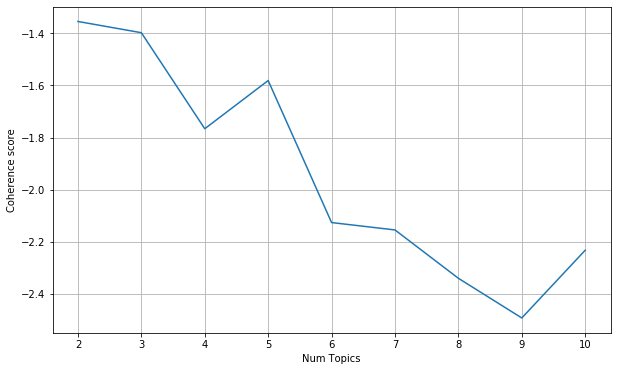

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creacción del Modelo


* Si que se aprecia que los artículos periodísticos estan bien clasificados en 5 temas, ya que según los valores de coherencia obtenidos aplicando el LDA para diferente número de temas (Topics), nos devuelve un valor de coherencia para 5 temas (Topics) alto en comparación con el resto de modelos.


In [7]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=7,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

<hr>


## Visualización para 5 Topics

In [8]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)